# Forecasting Data with CAQL

CAQL offers a few different forecasting methods based on regressions and exponential moving averages.

They can be used in a varity of different ways:

1. Forecast values for alerting and planning
2. Smooth out noisy data
3. Fill in missing data (as we have seen)
4. Detect anomalies

**CAVEAT:** The output of forecasting methods can be a little confusing. The problem is that CAQL follows a stric stream processing paradigma, so we can't plot forecasted value at future times, but emit them at the current processing step. You have to manually delay the forecast to make the visualization easier to read.

In [2]:
%run preamble.py
%matplotlib inline

## Slope Method

A very simple but powerful forecasting method is the slope method, illustrated in this figure:

![](img/forecast_slope.png)

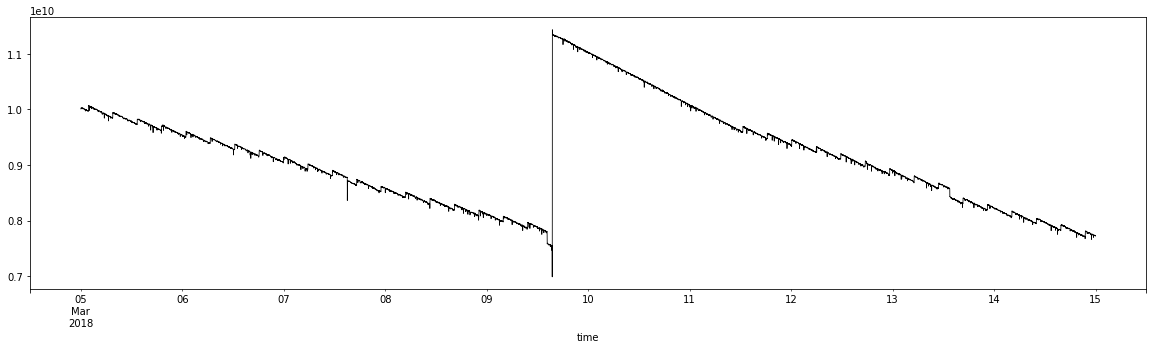

In [20]:
caql_plot("ops", """

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")

""", datetime(2018,3,5),60,60*24*10, color="black")

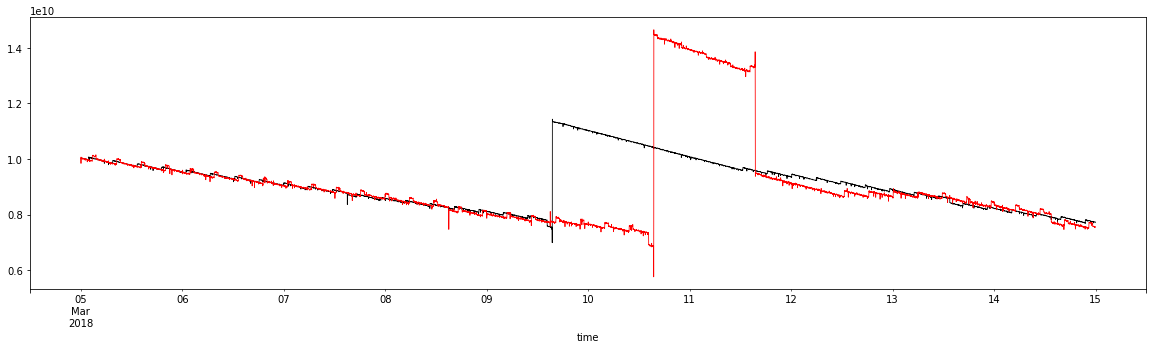

In [33]:
M = caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")

''', datetime(2018,3,5),60,60*24*10, color="black")
caql_plot("ops", """

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")
| forecasting:slope(1d, 1d) // 1h model period, 1h forecast
| delay(1d)       // Hold back forecasted data

""", datetime(2018,3,5),60,60*24*10, color="red", ax = M)

## Linear Regression

Another related method is linear regression, which we packaged as a stream processing function:

![](img/forecast_regression.png)

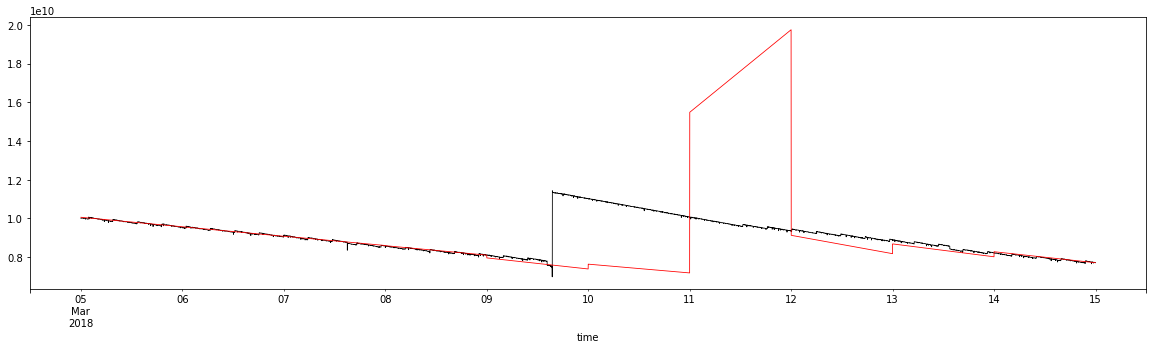

In [32]:
M = caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")

''', datetime(2018,3,5),60,60*24*10, color="black")
caql_plot("ops", """

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")
| forecasting:regression(1d,1d)
| delay(1d)

""", datetime(2018,3,5),60,60*24*10, color="red", ax = M)

## Application Alert on Forecasted Values

Say you want to alert on a situation where you run out of disk space in 3 days.

- Create a CAQL Check, that forcasts the data 3 days, e.g.

   ```
   metric:average(..., "df`percent_full") | forecasting:slope(1h, 3d)
   ```
   
   
- Create an alerting rule, on the metric being above 99.

# Forecasting Widget

Example HomeFX: https://hartmann.circonus.com/dashboards/view/861d2035-2a53-4372-9833-d6bbfdaeeda2

Example CaqlOps: https://circonus-ops.circonus.com/dashboards/view/53a65706-04ea-4c88-ac77-9bbe95fe4326

**TODO:** Provide good way to compute the time until out of ressources in CAQL.

**TODO:** Promote forecasting widget.

## Exponential Methods

* Exponentially Wighted Moving Average

* Double Exponentially Wighted Moving Average

* Triple Exponentially Wighted Moving Average = Holt Winters

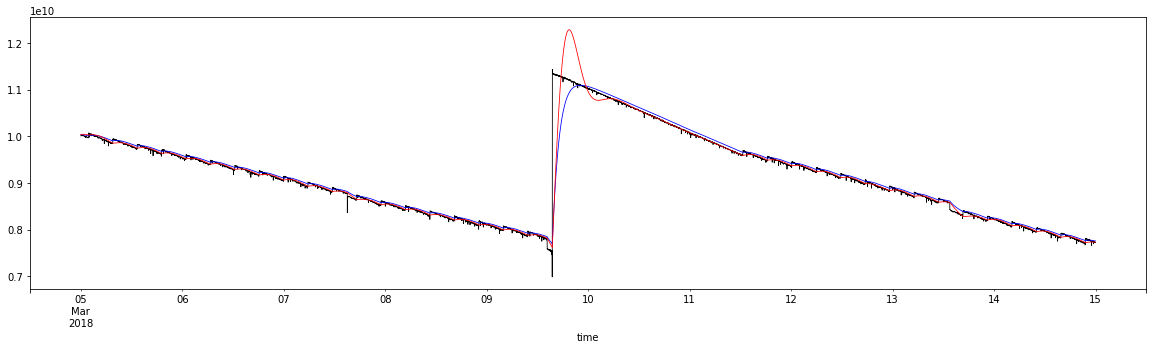

In [36]:
start = datetime(2018,3,5)
duration = 60*24*10

M = caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")

''', start,60, duration, color="black")
caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")
| forecasting:ewma(0.01)

''', start,60, duration, ax=M, color="blue")
caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")
| forecasting:dewma(0.01, 0.01)

''', start,60, duration, ax=M, color="red")

## Exponential smoothing of periodic data

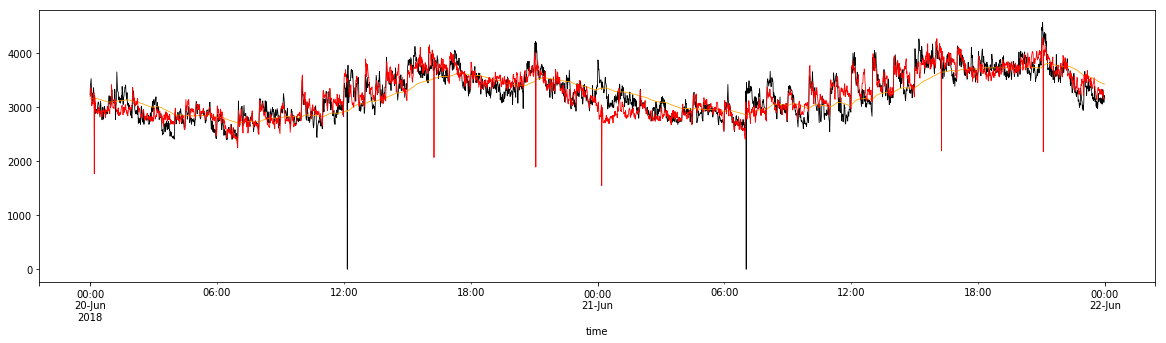

In [108]:
start = datetime(2018,6,20)
duration = 60 * 24 * 2

M = caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")

''', start, 60, duration, color="black")
caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")
| forecasting:ewma(0.01)

''', start, 60, duration, color="orange", ax=M)
caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")
| forecasting:holt_winters(0.01,0.001,0.001)

''', start, 60, duration, color="red", ax=M)


## Forecasting Period data with Holt Winters

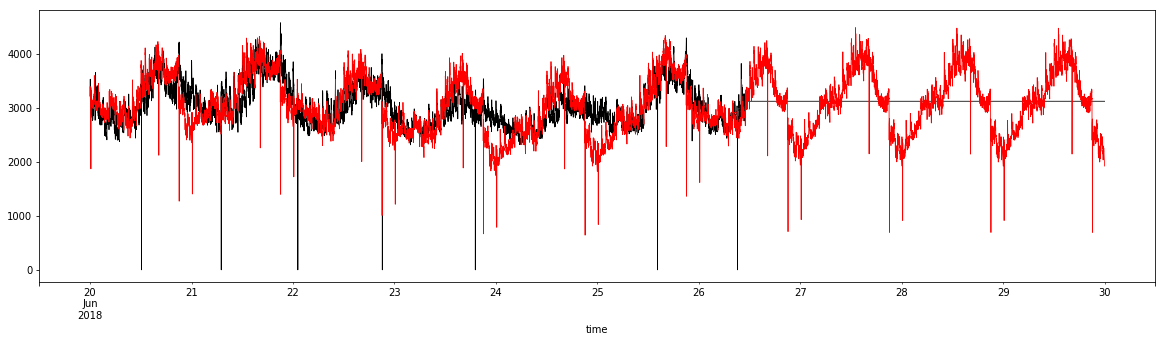

In [94]:
start = datetime(2018,6,20)
duration = 60 * 24 * 10

M = caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")

''', start, 60, duration, color="black")
caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")
| forecasting:holt_winters(0.01,0.001,0.001, forecast_duration=3h)
| delay(3h)

''', start, 60, duration, color="red", ax=M)

## Anomaly Detection

Anomaly detection uses forecasting method to arrive at expected values, and compares them against actual values coming in.
The CUSUM method is applied to the residuals to pick out significant changes.


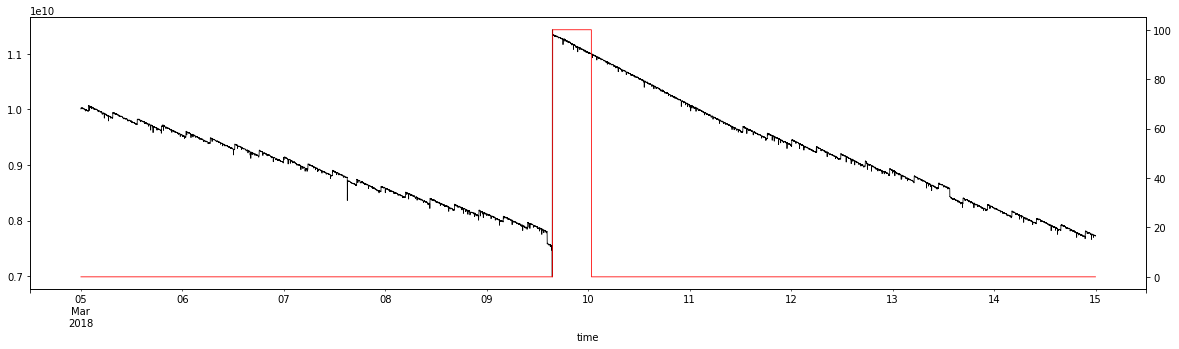

In [38]:
## AD Applied to trending data

start = datetime(2018,3,5)
duration = 60 * 24 * 10

M = caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")

''', start,60,duration, color="black")
caql_plot("ops", '''

metric:average("d46f3188-d39b-480a-943e-94e6d9140b50","vm`meminfo`MemFree")
| anomaly_detection(model="trending")

''', start,60,duration, ax=M.twinx(), color="red")

## Anomaly Detection applied to periodic data

**CAVEAT:** Tuning sensitivity parameter is delicate
    
**CAVEAT:** The periodic model needs a couple of days 3-10 to adapt to a new normal situation.

(0, 110)

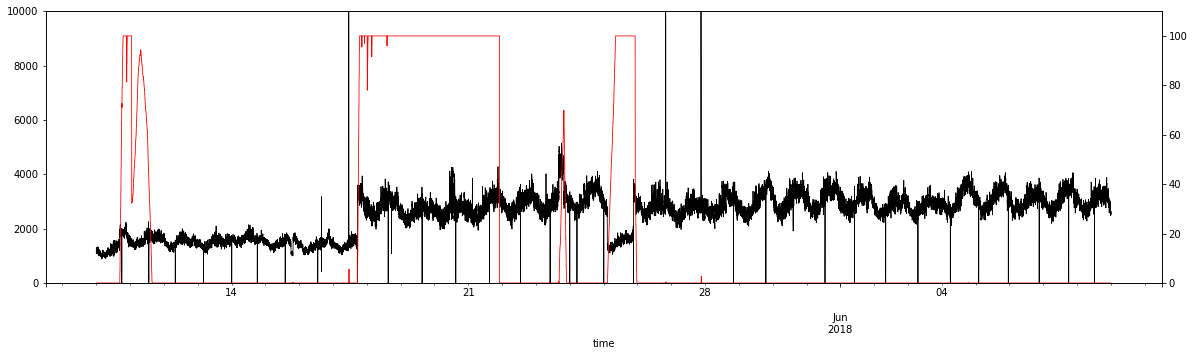

In [12]:
start = datetime(2018,5,10)
duration = 60 * 24 * 30

M = caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")

''', start, 60, duration, color="black")
M.set_ylim(0,10000)
caql_plot("ops", '''

metric:counter("2b45192d-1a16-4564-9123-a7907fef0461","mq`firehose")
| rolling:mean(5M)
| anomaly_detection(30,model="periodic")

''', start, 60, duration, color="red", ax=M.twinx()).set_ylim(0,110)